# Algorithmic Options Trading Using Python

                                     Date: September 4, 2021
                                     Author: J. Wojniak

## Abstract:
I evaluate trade entry rules for options trading utilizing vectorized backtesting.  The trading rules are based upon the 50-day simple moving average (SMA) and the 14-day %K stochastic technical indicator.  The trading strategy is evaluated using the Kelly Criterion.  If the trading strategy produces a positive expected return, the Kelly Criterion will be positive and provides the fraction of trading capital that maximizes the strategy return.  I then generalize the trading rules and utilize the SciPy optimization library to identify optimal values for the period of SMA and %K technical indicators.  Lastly, a support vector regressor (SVR) and random forest regressor (RFR) are each used to generate the trade entry signals to determine if strategy performance improves upon the trading rules' performance.  European option exercise is assumed.  European exercise provides a conservative result because the full amount of any losses are realized when the option expires (i.e. losses are not reduced by early exercise, a.k.a. American exercise).

## Methods, Algorithms, Techniques:
Vectorized backtesting, programmatic parameter optimization, in sample and out of sample strategy testing, support vector regressor (SVR), random forest regressor (RFR) ML model, Kelly Criterion.

## Python Packages:
Pandas, Numpy, SciPy, SciKitLearn,  Pickle, Jupyter Lab, Python 3.8.5, IPython 7.19.0

## Datasets, Sources:
3 years of stock and options data in csv format:
1. ge.stock.20080101.1231.csv
2. ge.stock.20090101.1231.csv
3. ge.stock.20100101.1231.csv
4. ge.options.20080101.1231.csv
5. ge.options.20090101.1231.csv
6. ge.options.20100101.1231.csv

Intermediary datafiles, for convenience:
1. ge_2008_raw_options.csv
2. ge_2008_options_returns.csv
3. ge_2009_raw_options.csv
4. ge_2009_options_returns.csv
5. ge_2010_raw_options.csv
6. ge_2010_options_returns.csv

ML models:
1. long_model-2021-09-03_1.pkl 
2. short_model-2021-09-03_1.pkl
3. regr_long_model-2021-09-03.pkl
4. regr_short_model-2021-09-03.pkl

### Source of datafiles: https://www.optionistics.com/

### Due Date: 1/28/2022

Option Trade Entry Rules

Downtrend (Underlying's price < 50 day SMA)
 1. If %K > 60 (overbought) and %K drops 5% then:
 2. Buy a >= 45 DTE 1 or 2 ITM Put with OI >= 100 and priced at bid-ask mid-point
 
Uptrend (Underlying's price > 50 day SMA)
1. If %K < 40 (oversold) and %K gains 5% then:
2. Buy a >= 45 DTE 1 or 2 ITM Call with OI >= 100 and priced at bid-ask mid-point

## Python Packages
Various Python packages are used to evaluate the trading strategies.  In order to prevent conflicts with existing projects, a new Conda environment was established- py_algo.  The .yaml file is provided so that the environment can be reproduced.

In [23]:
''' Imports dependencies used by this notebook and TrendStrategyBacktester.py
'''
import numpy as np
import pandas as pd
import os
from datetime import datetime, date, time, timedelta
from scipy.optimize import brute
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import pickle
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family']='serif'
import warnings
warnings.filterwarnings('ignore')

The following code imports and prepares an example dataset and calculates the %K stochastic indicator.  The subsequent code cells have been incorporated into TrendStrategyBacktester, demonstrated later.

In [3]:
''' Load the underlying stock's data
'''
equity_price_series = pd.read_csv('ge.stock.20080101.1231.csv', index_col=0, \
                                  parse_dates=True, infer_datetime_format=True)

highs = equity_price_series.iloc[:, 1]
lows = equity_price_series.iloc[:, 2]

H14 = highs.rolling(14).max()
L14 = lows.rolling(14).min()
equity_price_series['K'] = (100*(highs-L14)/(H14-L14)).shift(1)

equity_price_series['K_lag'] = equity_price_series['K'].shift(periods=1)
equity_price_series['K_change'] = equity_price_series['K']-equity_price_series['K_lag']

Calculate the underlying's mid price (high + low)/2 and shift the price series to avoid introducing foresight bias.

In [4]:
equity_price_series['mid'] = ((equity_price_series.iloc[:,1]+\
                               equity_price_series.iloc[:,2])/2).shift(1)

Calculate the 50 day SMA:

In [ ]:
equity_price_series['50sma'] = equity_price_series['mid'].rolling(50).mean()

Use np.where to identify trade entry points based upon the trading rules.

In [5]:
equity_price_series['trend'] = np.where(equity_price_series['mid']>\
                                        equity_price_series['50sma'], 1, -1)
equity_price_series['buy_call'] = np.where((equity_price_series['trend']==1)&\
                                           (equity_price_series['K']<=40), 1, 0)
equity_price_series['buy_put'] = np.where((equity_price_series['trend']==-1)&\
                                          (equity_price_series['K']>=60), 1, 0)
equity_price_series['buy_signal'] = np.where((equity_price_series['buy_call']==1)&\
                                            (equity_price_series['K_change']>=5), 1, 0)
equity_price_series['buy_signal'] = np.where((equity_price_series['buy_put']==1)&\
                                             (equity_price_series['K_change']<=-5), 1, 0)

Load the option data

In [6]:
options_chain = pd.read_csv('ge.options.20080101.1231.csv', index_col=0, \
                            parse_dates=True, infer_datetime_format=True)

The following combines the trading signals with the option data, so that trades may be selected later.
The mid-price is rounded to be an integer so that strikes may be selected in the money (ITM).
ffill is used to fill in missing values within the options_chain dataframe. ffill is used instead of bfill to prevent foresight bias.

In [7]:
signals = equity_price_series.copy()
signals = signals.loc[:, ['mid', 'buy_signal']]

signals['mid'] = np.around(signals.iloc[:, 0])

options_chain.fillna(method='ffill', inplace=True)

Option trading symbols are reused 6 months after expiry.  
Remove options that expire in 2009.

In [8]:
options_chain[' expiration'] = pd.to_datetime(options_chain[' expiration'],\
                                             infer_datetime_format=True)
options = options_chain[(options_chain[' expiration']<\
                         datetime.strptime('2009-01-01', '%Y-%m-%d'))]

The following creates a dataframe of options symbols and prices so that returns can be calculated for each option.

In [10]:
options_prices=pd.DataFrame(index=options.index)

In [12]:
for symbol in options[' symbol']:
    options_prices[symbol] = options.loc[(options[' symbol']==symbol), ' price']

In [13]:
options_prices.drop_duplicates(inplace=True)

The next step calculates option returns from the options_prices dataframe using a vectorized process.

In [14]:
%%time
options_returns = np.log(options_prices/options_prices.shift(1))

Wall time: 12 ms


We'll combine the trading signals with the options data so that trades can be selected and the strategy can be evaluated.

In [15]:
trades = options.merge(signals, how='left', left_index=True, right_index=True)

# buy puts
puts = trades.loc[(trades[' put/call']=='P')&(trades['buy_signal']==1)&\
                 (trades[' strike']==(trades['mid']-2))&\
                 (trades[' expiration']-trades.index>=timedelta(45))&\
                 (trades[' open interest']>100)&\
                 (trades[' price']<=(0.5*(trades[' ask']+trades[' bid'])))&\
                 (trades[' price']<=2.50)]

# buy calls
calls = trades.loc[(trades[' put/call']=='C')&(trades['buy_signal']==1)&\
                 (trades[' strike']==(trades['mid']+2))&\
                 (trades[' expiration']-trades.index>=timedelta(45))&\
                 (trades[' open interest']>100)&\
                 (trades[' price']<=(0.5*(trades[' ask']+trades[' bid'])))&\
                 (trades[' price']<=2.50)]

In [16]:
# data cleaning
options_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
traded_puts = puts[' symbol'].drop_duplicates().values
traded_calls = calls[' symbol'].drop_duplicates().values

We'll evaluate the trading strategy's returns by position over time graphically:

<AxesSubplot:>

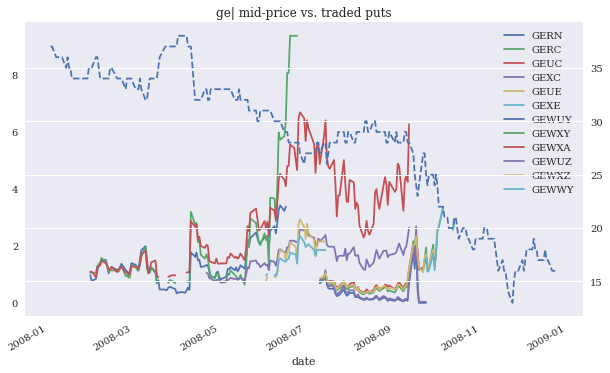

In [19]:
%matplotlib inline

ax = options_returns[traded_puts].cumsum().apply(np.exp).plot(figsize=(10,6))
trades['mid'].plot(ax=ax, secondary_y='mid', style='--', title='ge| mid-price vs. traded puts'\
                   , figsize=(10,6))

<AxesSubplot:>

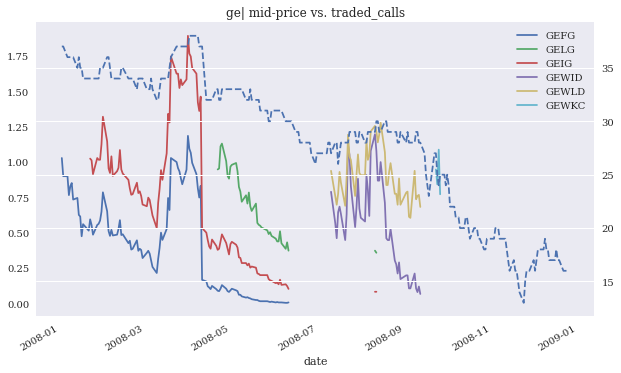

In [20]:
ax = options_returns[traded_calls].cumsum().apply(np.exp).plot(figsize=(10,6))
trades['mid'].plot(ax=ax, secondary_y='mid', style='--', title='ge| mid-price vs. traded_calls'\
                   , figsize=(10,6))

It's worthwhile noting that the trading rules selected calls but that these decreased in value as the underlying's bearish trend continued through-out 2008.

## Initial Trading Rules Strategy Results
The graphs of returns for traded puts and calls indicate that returns can be improved by implementing trading rules for early exercise vs. holding to expiration, particulary for contrarian trades that go against the longer term trend.  For 2008, the contrarian trades are buying calls in March and April before the underlying's price series reverses its upward movement at the end of April and resumes a bearish trend in May.

The next code cells evaluate the trading rules strategy outperformance and calculates the Kelly criterion.  The Kelly criterion is the fraction of trading capital that maximizes the strategy's returns.
We also need to establish a baseline for which to evaluate the trades by.  The concept of opportunity cost provides a rationale for the selected baseline.
## Defining the opportunity cost
The opportunity cost is the cost incurred by not selecting an alternative to the chosen investment.  That's why an index is often used as a benchmark comparison for a stock portfolio.  For options, the alternative investment is to purchase or to short the stock.
* The alternative to a put is to short the stock.
* The alternaive to a call is to buy the stock.
The log returns of the short position are given by
log(entry price/exit price).

In [24]:
cum_returns = pd.DataFrame(index=options_returns.index)
columns = list(options_returns.columns)
for col in columns:
    cum_returns[col] = options_returns[col].cumsum().apply(np.exp)
strat_crets = pd.DataFrame(index=options_returns.index)
for trade in traded_puts:
    strat_crets[trade] = cum_returns[trade]
for trade in traded_calls:
    strat_crets[trade] = cum_returns[trade]

In [25]:
aperf = 0
for trade in traded_puts:
    if strat_crets[trade].dropna().empty==True:
        continue
    else:
        aperf = aperf + strat_crets[trade].dropna().iloc[-1]
        
for trade in traded_calls:
    if strat_crets[trade].dropna().empty==True:
        continue
    else:
        aperf = aperf + strat_crets[trade].dropna().iloc[-1]

# out-/underperformance of strategy
underlying_short_perf = 0.0
underlying_long_perf = 0.0
underlying_short_rets = np.log(equity_price_series['mid'].shift(1)/equity_price_series['mid'])
underlying_short_perf = np.exp(underlying_short_rets.sum())
underlying_long_rets = np.log(equity_price_series['mid']/equity_price_series['mid'].shift(1))
underlying_long_perf = np.exp(underlying_long_rets.sum())   
operf = aperf - underlying_short_perf - underlying_long_perf
print('='*35)
print('Strategy performance: ', round(aperf, 2))
print('Underlying\'s  short performance: ', round(underlying_short_perf,2))
print('Underlying\'s  long performance: ', round(underlying_long_perf,2))
print('Strategy outperformance: ', round(operf,2))
''' Calculate the Kelly criteria f for the strategy
'''
wins = 0
wins_sum = 0.0
losses = 0
losses_sum = 0.0

for col in strat_crets.columns:
    if strat_crets[col].dropna().empty==True:
        continue
    elif strat_crets[col].dropna().iloc[-1] > 1:
        wins = wins + 1
        wins_sum = wins_sum + strat_crets[col].dropna().iloc[-1]
    else:
        losses = losses + 1
        losses_sum = losses_sum + strat_crets[col].dropna().iloc[-1]
p = wins/(wins+losses)
if p==1.0:
    print('Number of trades made: ', str(wins+losses))
    print('Trades won: ', str(wins))
    print('Trades lost: ', str(losses))
    print('Kelly criteria is N/A')
else:
    f = p/losses_sum + (1-p)/wins_sum
    print('Strategy Kelly criteria f: ', round(f, 2))
print('='*35)

Strategy performance:  37.57
Underlying's  short performance:  2.36
Underlying's  long performance:  0.42
Strategy outperformance:  34.79
Strategy Kelly criteria f:  0.31


Next, we'll optimize a few selected parameters of the trading rules strategy to determine whether this will improve the strategy's returns both in sample and out of sample vs. the baseline performance shown above-- strategy outperformance of 34.79.

In [26]:
import TrendStrategyBacktester as trend

In [29]:
%%time
trend_bt = trend.TrendVectorBacktester('ge', year='2008', K=14, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=50, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=False)

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2008_raw_options.csv
Loaded datafile: ge_2008_options_returns.csv
Object initialization complete.
Wall time: 160 ms


In [30]:
%%time
trend_bt.optimize_parameters((1, 14, 1), (1, 3, 1), (1, 71, 14))

Wall time: 1min 21s


(array([3., 1., 1.]), 88.3)

We plot the optimized results to visualize the returns over time vs. the underlying's price series.  We can see the inverse relationship between puts and the price series: puts' returns increase when the underlying's price decreases.

<AxesSubplot:>

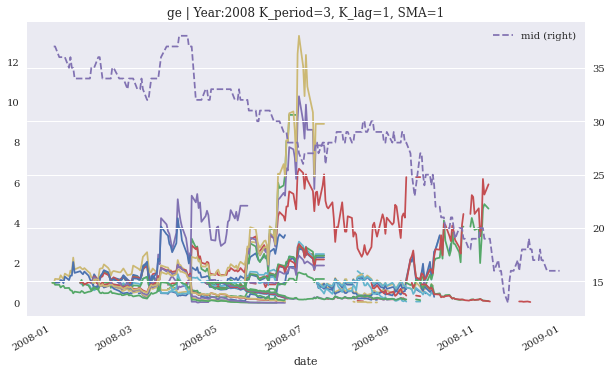

In [34]:
trend_bt.set_parameters(K=3, K_low=40, K_high=60, K_pos_change=5, K_neg_change=-5,\
     K_lag=1, SMA=1, DTE=45, ITM=2, OI=100, PRICE=2.50, print_true=False)

trend_bt.run_strategy()

ax = trend_bt.plot_results(legend=False)
trend_bt.stock_data['mid'].plot(ax=ax, secondary_y='mid', style='--', legend=True,\
                                figsize=(10,6))

In [35]:
trend_bt.set_parameters(K=3, K_low=40, K_high=60, K_pos_change=5, K_neg_change=-5,\
     K_lag=1, SMA=1, DTE=45, ITM=2, OI=100, PRICE=2.50, print_true=True)
trend_bt.run_strategy()

Strategy performance:  88.3
Underlying's short performance:  2.31
Underlying's long performance:  0.43
Strategy outperformance:  85.56
Strategy Kelly criteria f:  0.09


(88.3, 85.56, 0.09)

## Optimized Strategy Results
The optimized strategy has very high outperformance, 85.56. This is probably an indication of overfitting.  The next step is to run the optimized strategy out of sample to assess whether the optimized strategy may be viable.  We load data from 2009 to evaluate out of sample performance.

In [36]:
oos_bt = trend.TrendVectorBacktester('ge', year='2009', K=3, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=1, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2009_raw_options.csv
Loaded datafile: ge_2009_options_returns.csv
Object initialization complete.


In [37]:
oos_bt.run_strategy()

Strategy performance:  9.87
Underlying's short performance:  1.13
Underlying's long performance:  0.88
Strategy outperformance:  7.85
Strategy Kelly criteria f:  0.18


(9.87, 7.85, 0.18)

<AxesSubplot:>

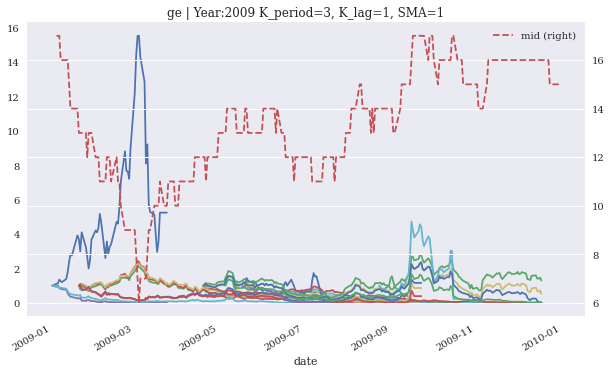

In [39]:
ax = oos_bt.plot_results(legend=False)
oos_bt.stock_data['mid'].plot(ax=ax, secondary_y='mid', style='--', legend=True, figsize=(10,6))

The optimized trading rule strategy's outperformance has declined greatly to 7.85 from 85.56.  Even with this decline, this may be an attractive strategy since the net returns would be 7.85 - 1 = 6.85 of the trading capital.  Strategies need to be evaluated relative to each other in order to judge whether a strategy is worth implementing.  We'll explore the effect of optimizing the trading rules on the 2009 data, which removes any effects of the bearish trend in the 2008 data that may have affected the optimization routine.  We'll also introduce two different machine learning models, SVR and RFR models, to replace the trade entry rules and evaluate the outperformance of these strategies.

The strategy outperformance results demonstrated so far are summarized in the table:

| Strategy | 2008 | 2009 | 2010 |
| ---------|------|------|------|
| Trading Rules | 34.79 | ---- | ---- |
| Optimized Rules | 85.56* | 7.85 | ---- |
| Optimized Rules | ---- | ---- | ---- |
| SVR | ----- | ----- | ----- |
| RFR | ----- | ----- | ----- |

    *In sample outperformance
    SVR = support vector regressor (ML strategy)
    RFR = random forest regressor (ML strategy)

In [40]:
trend_bt = trend.TrendVectorBacktester('ge', year='2009', K=14, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=50, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2009_raw_options.csv
Loaded datafile: ge_2009_options_returns.csv
Object initialization complete.


In [41]:
trend_bt.set_parameters(K=14, K_low=40, K_high=60, K_pos_change=5, K_neg_change=-5,\
     K_lag=1, SMA=50, DTE=45, ITM=2, OI=100, PRICE=2.50, print_true=False, Ns=5)

In [43]:
%%time
trend_bt.optimize_parameters((1, 14, 1), (1, 3, 1), (1, 71, 14))

Wall time: 1min 13s


(array([2., 1., 1.]), 26.39)

In [44]:
trend_bt.set_parameters(K=2, K_low=40, K_high=60, K_pos_change=5, K_neg_change=-5,\
     K_lag=1, SMA=1, DTE=45, ITM=2, OI=100, PRICE=2.50, print_true=True, Ns=5)
trend_bt.run_strategy()

Strategy performance:  26.39
Underlying's short performance:  1.13
Underlying's long performance:  0.88
Strategy outperformance:  24.37
Strategy Kelly criteria f:  0.1


(26.39, 24.37, 0.1)

In [45]:
trend_bt = trend.TrendVectorBacktester('ge', year='2010', K=2, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=1, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)
trend_bt.run_strategy()

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2010_raw_options.csv
Loaded datafile: ge_2010_options_returns.csv
Object initialization complete.
Strategy performance:  28.85
Underlying's short performance:  0.83
Underlying's long performance:  1.2
Strategy outperformance:  26.82
Strategy Kelly criteria f:  0.07


(28.85, 26.82, 0.07)

In [46]:
trend_bt = trend.TrendVectorBacktester('ge', year='2008', K=2, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=1, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)
trend_bt.run_strategy()

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2008_raw_options.csv
Loaded datafile: ge_2008_options_returns.csv
Object initialization complete.
Strategy performance:  39.7
Underlying's short performance:  2.31
Underlying's long performance:  0.43
Strategy outperformance:  36.95
Strategy Kelly criteria f:  0.14


(39.7, 36.95, 0.14)

After optimizing the trading rules on the 2009 data, we can now compare the out of sample performance in years 2008 and 2010.  This version of the optimized trading rules strategy is performing well, with slightly increased performance in 2010 with outperformance of 26.82 and with improved outperformance of 36.95 in 2008.

| Strategy | 2008 | 2009 | 2010 |
| ---------|------|------|------|
| Trading Rules | 34.79 | ---- | ---- |
| Optimized Rules | 85.56* | 7.85 | ---- |
| Optimized Rules | 36.95 | 24.37* | 26.82 |
| SVR | ----- | ----- | ----- |
| RFR | ----- | ----- | ----- |

   *In sample outperformance
    SVR = support vector regressor (ML strategy)
    RFR = random forest regressor (ML strategy)

## Machine Learning Strategies: SVR and RFR
The following section explores two different machine learning models the support vector regressor (SVR) and the random forest regressor (RFR).  The 2009 data will be used as training data, since it does not have a strong directional trend.  The 2010 and 2008 data will be used to test out of sample results.  The 2010 data has a similar neutral trend as 2009 while also being out of sample.  2008 is both out of sample and has a strong directional trend; it represents a strategy stress test.

In [47]:
trend_bt = trend.TrendVectorBacktester('ge', year='2009', K=2, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=1, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2009_raw_options.csv
Loaded datafile: ge_2009_options_returns.csv
Object initialization complete.


The following code cell uses the lagged mid-price as features and the SVR models will be used to predict the long returns and the short returns of the mid-price.  20% of the dataset will be used to train the models and to provide in sample error.  The remaining 80% of the dataset will be used to test the models and assess out of sample error.

In [51]:
# define the SVR model objects
long_model = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,\
                coef0=0)

short_model = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,\
                coef0=0)
# calculate the mid-price
data = trend_bt.stock_data[[' high', ' low']].copy()
data['mid'] = (data[' high']+data[' low'])*0.5
data['mid'] = data['mid'].shift(1)
# prepare features by lagging the mid-price
i=1
while i < 5:
    data['mid_'+str(i)] = data['mid'].shift(i)
    i = i + 1
data['lng_rets'] = np.log(data['mid']/data['mid'].shift(1))
data['shrt_rets'] = np.log(data['mid'].shift(1)/data['mid'])
# split 20% of the dataset off for training
split = int(len(data) * 0.20)
train = data.iloc[:split].copy()
train.dropna(inplace=True)

cols = ['mid', 'mid_1', 'mid_2', 'mid_3', 'mid_4']
long_model.fit(train[cols], train['lng_rets'])
short_model.fit(train[cols], train['shrt_rets'])

SVR(C=100, coef0=0, gamma='auto', kernel='poly')

In [52]:
# in sample error
error = train['lng_rets'] - long_model.predict(train[cols])
print(np.around(error.max(), 4), np.around(error.min(), 4), np.around(error.mean(), 4))

0.1005 -0.1004 0.0034


In [53]:
error_shrt = train['shrt_rets'] - short_model.predict(train[cols])
print(np.around(error_shrt.max(), 4), np.around(error_shrt.min(), 4), np.around(error_shrt.mean(), 4))

0.1006 -0.1003 -0.0039


The in sample error appears to be reasonable and roughly equivalent for predicting long returns and for predicting short returns.  The average error for predicting long returns is 0.0034.  The average error for predicting short returns is -.0039.  The maximum and minimum errors are also roughly symmetrical about zero: 0.1005, -0.1004 and 0.1006, -0.1003.  This is an indication that the predictions do not have a strong error bias, so we will evaluate the models for out of sample error.

In [54]:
# out of sample error
test = data[split:]
error = test['lng_rets'] - long_model.predict(test[cols])
print(np.around(error.max(), 4), np.around(error.min(), 4), np.around(error.mean(), 4))

0.0907 -0.1329 -0.0109


In [55]:
error_shrt = test['shrt_rets'] - short_model.predict(test[cols])
print(np.around(error_shrt.max(), 4), np.around(error_shrt.min(), 4), np.around(error_shrt.mean(), 4))

0.1301 -0.0924 0.0097


The out of sample error is higher than the in sample error, as expected.  The out of sample error is slightly asymmetric.  The maximum, minimum, and average for the long returns prediction error are 0.0907, -0.1329, and -0.109.
The same for the short returns prediction error are 0.1301, -0.0924, and 0.0097.  We'll evaluate a modified version of the trading strategy, substituting the SVR model for the optimized trading rules and assess the strategy's outperformance.

In [56]:
trend_bt = trend.TrendVectorBacktester('ge', year='2009', K=2, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=1, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2009_raw_options.csv
Loaded datafile: ge_2009_options_returns.csv
Object initialization complete.


In [57]:
trend_bt.run_strategy(SVR=True)

Strategy performance:  9.88
Underlying's short performance:  1.07
Underlying's long performance:  0.94
Strategy outperformance:  7.88
Strategy Kelly criteria f:  0.17


(9.88, 7.88, 0.17)

In [59]:
trend_bt = trend.TrendVectorBacktester('ge', year='2010', K=2, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=1, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)
trend_bt.run_strategy(SVR=True)

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2010_raw_options.csv
Loaded datafile: ge_2010_options_returns.csv
Object initialization complete.
Strategy performance:  28.85
Underlying's short performance:  0.89
Underlying's long performance:  1.12
Strategy outperformance:  26.84
Strategy Kelly criteria f:  0.07


(28.85, 26.84, 0.07)

In [60]:
trend_bt = trend.TrendVectorBacktester('ge', year='2008', K=2, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=1, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)
trend_bt.run_strategy(SVR=True)

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2008_raw_options.csv
Loaded datafile: ge_2008_options_returns.csv
Object initialization complete.
Strategy performance:  39.7
Underlying's short performance:  2.25
Underlying's long performance:  0.44
Strategy outperformance:  37.0
Strategy Kelly criteria f:  0.14


(39.7, 37.0, 0.14)

<AxesSubplot:>

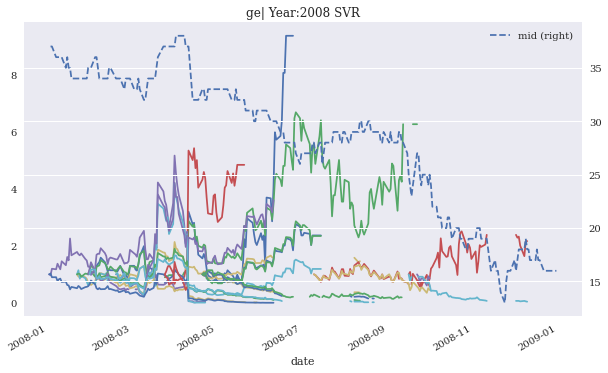

In [61]:
ax = trend_bt.plot_results(legend=False)
trend_bt.stock_data['mid'].plot(ax=ax, title='ge| Year:2008 SVR', legend=True,\
                                secondary_y='mid', style='--', figsize=(10,6))

Somewhat surprisingly, the strategy utilizing the SVR models perform better out of sample (2008 and 2010) than in sample (2009) with outperformance of 37.00 in 2008, 7.88 in 2009, and 26.84 in 2010.  For comparison purposes, the table below shows each strategy's outperformance per year.  The last ML model we will investigate is the random forest regressor.

| Strategy | 2008 | 2009 | 2010 |
| ---------|------|------|------|
| Trading Rules | 34.79 | ---- | ---- |
| Optimized Rules | 85.56* | 7.85 | ---- |
| Optimized Rules | 36.95 | 24.37* | 26.82 |
| SVR | 37.00 | 7.88* | 26.84 |
| RFR | ----- | ----- | ----- |

In [ ]:
    *In sample outperformance
    SVR = support vector regressor (ML strategy)
    RFR = random forest regressor (ML strategy)

In [62]:
trend_bt = trend.TrendVectorBacktester('ge', year='2009', K=2, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=1, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2009_raw_options.csv
Loaded datafile: ge_2009_options_returns.csv
Object initialization complete.


The following code cell uses the same features as were used with the SVR models, lagged mid-price.  The random forest regressor supports the calculation of R-squared, a measure of prediction accuracy and will be used to assess model performance.

In [63]:
regr_long_model = RandomForestRegressor(max_depth=20, random_state=0)
regr_short_model = RandomForestRegressor(max_depth=20, random_state=0)

cols = ['mid', 'mid_1', 'mid_2', 'mid_3', 'mid_4']
regr_long_model.fit(train[cols], train['lng_rets'])
regr_short_model.fit(train[cols], train['shrt_rets'])

RandomForestRegressor(max_depth=20, random_state=0)

In [65]:
''' In sample accuracy - Random Forest Regressor
'''
np.around(regr_long_model.score(train[cols], train['lng_rets']), 4)

0.8777

In [66]:
np.around(regr_short_model.score(train[cols], train['shrt_rets']), 4)

0.8828

In [68]:
''' Out of sample R-squared Accuracy - Random Forest Regressor
'''
np.around(regr_long_model.score(test[cols], test['lng_rets']), 4)

-0.8517

In [69]:
np.around(regr_short_model.score(test[cols], test['shrt_rets']), 4)

-0.7762

The out of sample R-squared is negative for both random forest regressor models.  This indicates that the model is predicting inverted results out of sample.  The in sample R-squared values were reasonably high 0.8777 and 0.8828 out of 1.0 (1.0 being perfect prediction).  These models will be used in the trading strategy to investigate the impact of poor out of sample R-squared on strategy returns.

In [70]:
trend_bt = trend.TrendVectorBacktester('ge', year='2009', K=2, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=1, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)
trend_bt.run_strategy(RFR=True)

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2009_raw_options.csv
Loaded datafile: ge_2009_options_returns.csv
Object initialization complete.
Strategy performance:  31.37
Underlying's short performance:  1.07
Underlying's long performance:  0.94
Strategy outperformance:  29.37
Strategy Kelly criteria f:  0.09


(31.37, 29.37, 0.09)

In [71]:
trend_bt = trend.TrendVectorBacktester('ge', year='2010', K=2, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=1, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)
trend_bt.run_strategy(RFR=True)

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2010_raw_options.csv
Loaded datafile: ge_2010_options_returns.csv
Object initialization complete.
Strategy performance:  31.53
Underlying's short performance:  0.89
Underlying's long performance:  1.12
Strategy outperformance:  29.51
Strategy Kelly criteria f:  0.05


(31.53, 29.51, 0.05)

In [72]:
trend_bt = trend.TrendVectorBacktester('ge', year='2008', K=2, K_low=40, K_high=60,\
                                       K_pos_change=5, K_neg_change=-5,\
                                       K_lag=1, SMA=1, DTE=45, ITM=2, \
                                       OI=100, PRICE=2.50, start='01-01',\
                                       end='12-31', print_true=True)
trend_bt.run_strategy(RFR=True)

Getting stock data
Stock data load successful.
%K stochastic oscillator calculated.
SMA calculated.
Getting option data
Loaded datafile: ge_2008_raw_options.csv
Loaded datafile: ge_2008_options_returns.csv
Object initialization complete.
Strategy performance:  0
Underlying's short performance:  2.25
Underlying's long performance:  0.44
Strategy outperformance:  -2.69
Number of trades made:  0
Trades won:  0
Trades lost:  0
Kelly criteria is N/A


(0, -2.69, 1.0)

## Random Forest Regressor's Results
The random forest classifier models, one for long returns and one for short returns, had high R-squared in sample (0.8777 and 0.8828, respectively) and negative R-squared out of sample (-0.8517, -0.7762).  These models were applied to the trading strategy and these strategy's performed well in 2009 and 2010 with strategy returns of 29.37 and 29.51.  However, the RFR model strategy had a negative -2.69 return in 2008.  We'll recall that 2008 had a strong bearish trend.  The RFR models appear to perform well for similar datasets (2009 and 2010) but if the dataset departs significantly from the learned dataset (2009) then the strategy performs poorly.

The strategy outperformance results are summarized in the table:

| Strategy | 2008 | 2009 | 2010 |
| ---------|------|------|------|
| Trading Rules | 34.79 | ---- | ---- |
| Optimized Rules | 85.56* | 7.85 | ---- |
| Optimized Rules | 36.95 | 24.37* | 26.82 |
| SVR | 37.00 | 7.88* | 26.84 |
| RFR | -2.69 | 29.37* | 29.51 |

    *In sample outperformance
    SVR = support vector regressor (ML strategy)
    RFR = random forest regressor (ML strategy)

## Summary and Conclusions
We investigated a rules based trading strategy, optimized the trading rules and then compared these results with two machine learning models, the support vector regressor (SVR) and the random forest regressor (RFR).  The optimized trading rules performed well if trained on a dataset that did not have a strong directional trend with outperformance between 24.37 and 36.95.  The SVR performed better out of sample than in sample, but did provide positive outperformance in each year 2008 to 2010.  The RFR performed well in sample (2009) and out of sample if the data was similar to the training sample- the outperformance for 2010 was similar to 2009 (29.51 and 29.37, respectively).  The RFR did not do well with the 2008 data, which had a strong directional trend; RFR outperformance was -2.69 for 2009.  The negative outperformance in 2009 may be the result of the RFR's negative R-squared out of sample results.

## Extensions
There are additional areas that could be explored in the future:
1. Study the effects of optimizing additional trading rule parameters, both for trade entry and for option selection.
2. Implement trade exit rules before expiration.
3. Explore features for ML model refinement, other types of ML models, and using ML models to select options.